In [1]:
#https://intellica-ai.medium.com/aspect-based-sentiment-analysis-everything-you-wanted-to-know-1be41572e238
#https://medium.datadriveninvestor.com/sentiment-analysis-is-not-enough-ffafc8bbbfeb
#https://www.kaggle.com/code/phiitm/aspect-based-sentiment-analysis/notebook
#https://medium.com/analytics-vidhya/aspect-based-sentiment-analysis-a-practical-approach-8f51029bbc4a

In [1]:
%%capture
!python3 -m pip install tweepy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg
!pip install stanfordnlp

In [3]:
#import libraries
import pandas as pd
import string
from tqdm.notebook import tqdm_notebook
import warnings
import time
import csv
import base64
import json

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words()

import spacy
import re

# load a trained English pipeline 
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import stanfordnlp

from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from transformers import pipeline


import tweepy
from tweepy import OAuthHandler

# initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankushsingal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [409]:
# suppress all warnings
warnings.simplefilter('ignore')

# expand notebook display options for dataframes
pd.set_option('display.max_colwidth', 200)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 300

In [430]:
#twitter credentials
consumer_key = "EhOZiQEfg2b8HfBeKjhX9ezB6"
consumer_secret = "jbJcZi5g5qGSYrIGzaatDuiYPg8QpYfURdjmfbfgZZk5RUYvgb"
access_token = "232661448-pdfmND03rvRkbPDWPfUGxuHY8ZHOENkNLSHZarPr"
access_token_secret = "CFAcNGLqMM24Nh8m3uQglb6CSpYU5vZtTp9j4Xvd7bB5S"
hashtag='oneplus7pro'
tweet_count=50

# #Authenticate credentials
# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth,wait_on_rate_limit=True)

# tweet_created = []
# tweet_text = []
# tweets = tweepy.Cursor(api.search_tweets,q='hare krsna',count=30, lang="en")
# for tweet in tweets.items():
#     tweet_created.append(tweet.created_at)
#     tweet_text.append(tweet.text)  

# df = pd.DataFrame(columns=['created_on','tweets'])
# df['created_on'] = tweet_created
# df['tweets']= tweet_text

In [431]:
#method to fetch tweets from twitter
def get_tweets(hashtag, consumer_key, consumer_secret, access_token, access_token_secret, tweet_count):
    #authentication using credentials
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth,wait_on_rate_limit=True)

    #fetching tweets holding specific hashtag
    tweet_text, tweet_created = list(), list()
    for tweet in tweepy.Cursor(api.search_tweets,q=hashtag, count=tweet_count, lang="en").items():
        tweet_text.append(tweet.text.encode('utf-8'))
        tweet_created.append(tweet.created_at)
       
    #creating dataframe    
    df = pd.DataFrame({'tweets': tweet_text, 'created_on': tweet_created})
    return df

In [432]:
twitter_content = get_tweets(hashtag, consumer_key, consumer_secret, access_token, access_token_secret, tweet_count=50)

In [433]:
#twitter_content

# Data Cleaning

Extracted tweet text may contain hashtags, tagging account, emojis, web-site/HTTP links, and HTML tags that need to be removed in pre-processing steps.

In [434]:
import re
from urlextract import URLExtract
extractor = URLExtract()
import contractions
import nltk


def preprocess(text):
    #to lowercase
    text = str(text).lower()
    #remove urls
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, '')
    #remove new lines
    text = text.replace('\\n',' ')
    #remove none meaningful    
    text = re.sub(r'\\x[0-9a-f]{2}', '',text)
    #remove emails
    text = re.sub(r'\S*@\S*\s?',' ',text)
    #remove mentions
    text = re.sub(r'@\S+', ' ', text)
    #contractions
    text = contractions.fix(text)
    #remove hashtags
    text = re.sub(r'@\S+', ' ', text)
    #remove emojis
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    #remove retweets
    text = text.replace(r'rt', '')
    #remove all punct
    text = re.sub('[^A-z0-9]', ' ', text)
    #remove extras whitespaces
    text = re.sub('\s+', '', text)
    return text

# Extracting Nouns and Synonyms
The aspects provided by the user during an invocation are used in this phase. Nouns are extracted from tweets as aspects might be mentioned in tweets as alternate terms. For instance, a “screen” can be called a “display” for a product like a cell phone. To extract such terms which are directly correlated with aspects, we extract all nouns from tweets. Thereafter, we find similarities between extracted nouns and aspects to know the nouns which are alternate names used for aspects in tweets.

Nouns are extracted using part-of-speech (POS), an NLP technique that assigns the part-of-speech to every token of text. Part of speech might be nouns, pronouns, adjectives, adverbs, etc. Part-of-speech assigns one of this grammar entities to every token of a sentence.

In [435]:
def get_noun(lines):
	tokenized = nltk.word_tokenize(lines)
	#extracts token whose pos ends with 'NN' i.e. extracts any type of noun whether proper or common
	nouns = set([word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')])
	return nouns

# https://www.geeksforgeeks.org/aspect-modelling-in-sentiment-analysis/

In [11]:
# ext_aspects = []
  
# # Performing Aspect Extraction
# for sen in df.preprocess_data:
#   important = nlp(sen)
#   descriptive_item = ''
#   target = ''
#   for token in important:
#     if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
#       target = token.text
#     if token.pos_ == 'ADJ':
#       added_terms = ''
#       for mini_token in token.children:
#         if mini_token.pos_ != 'ADV':
#           continue
#         added_terms += mini_token.text + ' '
#       descriptive_item = added_terms + token.text
#   ext_aspects.append({'aspect': target,
#     'description': descriptive_item})
  
# print("ASPECT EXTRACTION\n")
# # df.append(ext_aspects)

2. Synonyms are extracted using word similarity between aspects provided and nouns extracted in the previous step. Word similarity is computed using spacy’s English large model. This model provides us with the embedding of both the words, the first being the noun and the second being the aspect. Embedding is the numeric representation of words. Then, cosine similarity is computed of both words’ embedding using the “similarity” method of spacy. It is used to find synonyms used for aspects in specific tweets.

For instance, the user has passed the aspects “screen” and “price” as aspects during invocation and “display” is the noun extracted from the tweet then cosine similarity will be high for “display” and “screen” as compared to “display” and “price”. Hence, we can conclude that “display” is the synonym used in place of aspect “screen” in the tweet. Here, we consider two words as similar only if their cosine similarity is greater than 60 percent.

In [405]:
#loading the english large model
nlp = spacy.load('en_core_web_lg')
#method to get list of aspects and their respective noun representations
def get_similar_words(nouns, aspects):
	aspect_classes = {k: list() for k in aspects}
	for noun in nouns:
		scores = list()
		for aspect in aspects:
			#get embedding of both words (aspect and noun)
			aspect_token = nlp(aspect)
			noun_token = nlp(noun)
			#get similarity of both embedding
			similarity_score = aspect_token.similarity(noun_token)
			scores.append(similarity_score)
		index = scores.index(max(scores))
		aspect_name = aspects[index]
		
		#check if similarity score is greater than 60 percent
		if max(scores)>0.60:
			value = aspect_classes[aspect_name]
			value.append(noun)
			aspect_classes[aspect_name] = list(set(value))
			
		else:
			pass
	return aspect_classes	

# Extract Describing phrases
Sentiment can be computed on the phrases which are used to describe the aspects. Adjectives and adverbs form such phrases which describe the nouns. To extract such describing phrases, we have used the question-answering model. We haven’t trained a custom question-answering model but used one available from hugging face. More details about the question-answering model are mentioned in my GitHub repository, mentioned at the end of this article. We have used the preprocessed tweet as context and asked questions in the following format: “how is {aspect_name}”.

This question extracts the describing phrases from the context for every aspect. For instance, a tweet after preprocessing states as “iPhone 13’s design is fantastic but the camera is disappointing”. Using it as context and asking questions such as “how is design” and “how is a camera” will yield answers such as “fantastic” and “disappointing” respectively.

Note: For the question-answering model, it is necessary to maintain to grammar and lexical meaning of the tweet, that is why we have not removed stop words during preprocessing step.



In [13]:
qa_tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
qa_model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
qa_model = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer)

sent_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
sent_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
sent_model = pipeline('text-classification', model=sent_model, tokenizer=sent_tokenizer)

In [14]:
def get_sentiment(aspect_classes, text,qa_model, sent_model):
    sentiment_dict = {k:0 for k in aspect_classes}
    for aspect in aspect_classes:
        alt_names = aspect_classes[aspect]
        for name in alt_names:
            question = f'how is {name}'
            QA_input = {'question': question, 'context': text}
            qa_result = qa_model(QA_input)
            answer = qa_result['answer']

        #sentiment model 
            sent_result = sent_model(answer)    
            print(sent_result)
            sentiment = sent_result[0]['label']

            if sentiment == 'LABEL_0':
                sentiment, score = 'Negative', -1
            elif sentiment == 'LABEL_1':
                sentiment, score = 'Neutral', 0
            else:
                sentiment, score = 'Positive', 1

            value = sentiment_dict[aspect] + score
            sentiment_dict[aspect] = value
    return sentiment_dict

def compute(text, aspects, qa_model, sent_model):
	#preprocessing
	preprocess_text = preprocess(text)
	#get nouns
	noun_list = get_noun(preprocess_text)	
	#get alternative names of aspects
	aspect_classes = get_similar_words(noun_list, aspects)
	#get sentiment
	sentiment_result = get_sentiment(aspect_classes, text, qa_model, sent_model)
	return sentiment_result


In [15]:
def aspect_sentiment(aspects, hashtag):
	if not aspects or aspects == list() :
		return {'statusCode': 400, 'body': 'aspects not found in request'}

	if not hashtag or hashtag.strip() == '':
		return {'statusCode': 400, 'body': 'hashtag not found in request'}

	#extracts 50 tweets regarding the hashtag from twitter
	twitter_content = get_tweets(hashtag, consumer_key, consumer_secret, access_token, access_token_secret, tweet_count=50)
	aspect_score = {asp : {'positive': 1, 'negative': -1} for asp in aspects}
	
	#compute scores for each tweet
	if twitter_content.to_dict():
		for text in twitter_content['tweets']:
			sentiment_result = compute(text, aspects, qa_model, sent_model)
			for result in sentiment_result:
				score = sentiment_result[result]
				if score>0:
					aspect_score[result]['positive'] = aspect_score[result]['positive'] + score
				elif score<0:
					aspect_score[result]['negative'] = aspect_score[result]['negative'] - score
				else:
					pass
	else:
		return {'statusCode': 400, 'body': 'No twitter data scraped for this hashtag'}



	result_list = [[k, 'positive', v['positive']] for k,v in aspect_score.items()]
	result_list.extend([[k, 'negative', v['negative']] for k,v in aspect_score.items()])

	#plot the bar plot across all aspects
	aspects_df = pd.DataFrame(result_list, columns= ['aspect', 'sentiment', 'score'])
	sns.barplot(x = 'aspect', y = 'score', hue='sentiment', data=aspects_df)
	plt.savefig('result.png')
    

	#send base64 string of image as response
	img_result = None
	with open('result.png', 'rb') as f:
		im_b64 = base64.b64encode(f.read())
		img_result = str(im_b64)
	if img_result:
		return {'statusCode': 200, 'body': json.dumps(img_result)}
	else:
		return {'statusCode': 400, 'body': 'issue in saving result image'}

In [16]:
aspects = ['screen', 'battery', 'design', 'camera']


{'statusCode': 200,
 'body': '"b\'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZpAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAis0lEQVR4nO3de3RU5d328e9FBEHFEyJFMII+VEVQrBFRtEURRR8tRVE8vJXWWsSKWqv40tZjta313NcTRR8KrQc8otRSRRAePFYIRgQURUUNoCJWWlBU8Pf+MTtxDJMQIJnMTq7PWlnZh3vv/Zu9sri475m5tyICMzOztGnW0AWYmZltDAeYmZmlkgPMzMxSyQFmZmap5AAzM7NUcoCZmVkqOcDMzCyVHGBmZpZKDjAzM0slB5iZmaWSA8zMzFLJAWZmZqnkADMzs1RygJmZWSo5wMzMLJUcYGZmlkoOMDMzSyUHmJmZpZIDzMzMUskBZmZmqeQAMzOzVHKAmZlZKjnAzMwslRxgZmaWSg4wMzNLJQeYmZmlkgPMzMxSyQFmZmap5AAzM7NUcoCZmVkqOcDMzCyVHGBmZpZKDjAzM0slB5iZmaXSZg1dQH3ZYYcdolOnTg1dhplZqpSWln4UEW0buo7aaLQB1qlTJ2bNmtXQZZiZpYqkdxq6htryEKKZmaWSA8zMzFLJAWZmZqmUt/fAJI0BjgE+jIhuOfYL+CNwNPAp8KOImJ3s65/sKwLujIir81W3mRWuL7/8kvLyclavXt3QpaROy5Yt6dixI82bN2/oUjZaPj/EMRa4BfhLNfuPArokPwcAtwMHSCoCbgX6AeXATEkTI2J+vVdsZgWtvLyc1q1b06lTJzL/B7baiAiWL19OeXk5nTt3buhyNlrehhAjYgbwcQ1NBgB/iYwXgG0ltQd6Agsj4q2I+AIYn7Q1syZu9erVtGnTxuG1gSTRpk2b1P

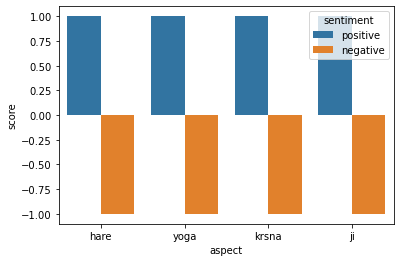

In [17]:
aspect_sentiment(aspects, hashtag)

In [18]:
# aspect_score = {asp : {'positive': 1, 'negative': -1} for asp in aspects}

In [19]:
# if twitter_content.to_dict():
# 		for text in twitter_content['tweets']:
# 			sentiment_result = compute(text, aspects, qa_model, sent_model)
# 			for result in sentiment_result:
# 				score = sentiment_result[result]
# 				if score>0:
# 					aspect_score[result]['positive'] = aspect_score[result]['positive'] + score
# 				elif score<0:
# 					aspect_score[result]['negative'] = aspect_score[result]['negative'] - score
# 				else:
# 					pass


In [20]:
# result_list = [[k, 'positive', v['positive']] for k,v in aspect_score.items()]

In [21]:
# result_list.extend([[k, 'negative', v['negative']] for k,v in aspect_score.items()])

In [22]:
# aspects_df = pd.DataFrame(result_list, columns= ['aspect', 'sentiment', 'score'])

In [23]:
# sentiment_result

In [24]:
!pip install monkeylearn
!pip install textblob

You should consider upgrading via the '/Users/ankushsingal/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/ankushsingal/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [436]:
from monkeylearn import MonkeyLearn
from textblob import TextBlob

In [437]:
# instantiate the client using your API key
ml = MonkeyLearn('9ee10f9c870c25dcd0ffcc64b9ceb47fbe06b34b')

# opinion unit extractor
model_id = 'ex_N4aFcea3'

In [438]:
def preprocess2(text):
    #to lowercase
    text = str(text).lower()
    #remove urls
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, '')
    #remove new lines
    text = text.replace('\\n',' ')
    #remove none meaningful    
    text = re.sub(r'\\x[0-9a-f]{2}', '',text)
    #removes retweets & cc
    text = text.replace(r'rt', '')
    #remove emails
    text = re.sub(r'\S*@\S*\s?',' ',text)
    #remove mentions
    text = re.sub(r'@\S+', ' ', text)
    #contractions
    text = contractions.fix(text)
    #remove hashtags
    text = re.sub(r'@\S+', ' ', text)
    #remove emojis
    text = re.sub(r'[^\x00-\x7f]+', ' ', text)

    #remove all punct
    text = re.sub('[^A-z0-9]', ' ', text)
    #remove extras whitespaces
    text = re.sub(' +', ' ', text)
    return text

In [419]:
import numpy as np

In [441]:
twitter_content2 = get_tweets(hashtag, consumer_key, consumer_secret, access_token, access_token_secret, tweet_count=50)

In [442]:
twitter_content2['tweets'] = twitter_content2['tweets'].apply(preprocess2)

In [443]:
twitter_content2.dropna(how="any", inplace=True)


In [444]:
# twitter_content2.drop([112,166], axis=0,inplace=True)

In [447]:
twitter_content2

,tweets,created_on
0,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,2022-07-09 21:41:48+00:00
1,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,2022-07-09 13:54:35+00:00
2,b 2019 s oneplus 7 oneplus 7t oneplus 7 pro oneplus 7t pro series will soon receive oxygenos 12 stable update,2022-07-09 10:00:14+00:00
3,notingphone1 coming soon i am oneplus7pro user,2022-07-08 21:31:57+00:00
4,i was using oneplus7pro and after having system update it got slow and it took more time to charge s,2022-07-08 19:17:31+00:00
5,oneplus7pro now it is coz of updates,2022-07-07 16:59:28+00:00
6,b oneplus 7 pro 7t and 7t pro can try paranoid android sapphire beta 2 news oneplus7pro oneplus7t oneplus7tpro,2022-07-05 13:05:56+00:00
7,b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,2022-07-03 17:05:56+00:00
8,b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,2022-07-03 15:34:31+00:00
9,wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,2022-07-03 14:53:43+00:00


In [448]:
# def opinion_parser(text):
#     """
#       Extract the individual opinion unit (or phrase) within the text
#       that contains the aspect term. 
#     """
#     result = ml.extractors.extract(model_id, [text])
#     time.sleep(1)
  
#     extractions = result.body[0]['extractions']

#     num__opinion_units = len(extractions)

#     for i in range(num__opinion_units):
#         opinion_unit = "".join([extractions[i]['extracted_text']])
    
#         if re.search("colors?", opinion_unit):
#              return opinion_unit
  
#     return ""

In [449]:
#twitter_content2[""] = twitter_content2["tweets"].progress_apply(opinion_parser)

In [450]:
data = [text for text in twitter_content2["tweets"]]
result = ml.extractors.extract(model_id, data)
dataDict = len(result.body)
#extractions = result.body[0]['extractions']
num1 = ["".join([result.body[i]['extractions'][0]['extracted_text']]) for i in range(dataDict)]
# # for item in dataDict[0]['extractions']['extracted_text']:
# #   print(item['parsed_value'])
# # for i in range(dataDict):
# #         opinion_unit = "".join([extractions[i]['extracted_text']])
# # return opinion_unit
num1
#extractions

['b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo',
 'b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo',
 'b 2019 s oneplus 7 oneplus 7t oneplus 7 pro oneplus 7t pro series will soon receive oxygenos 12 stable update',
 'notingphone1 coming soon i am oneplus7pro user',
 'i was using oneplus7pro and after having system update it got slow and it took more time to charge s',
 'oneplus7pro now it is coz of updates',
 'b oneplus 7 pro 7t and 7t pro can try paranoid android sapphire beta 2 news oneplus7pro oneplus7t oneplus7tpro',
 'b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro',
 'b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro',
 'wallpapers dotted everywhere in wales oneplus9pro oneplus7pro',
 'b oneplus 8 pro will have 120hz display \\ breakingnews oneplus oneplus8 oneplus7pro oneplus7t of',
 'b oppo reno 10x zoom review price features \\ oppo opporeno oppof11pro

In [451]:
twitter_content2["Opinion"] = num1
      
twitter_content2.head()

,tweets,created_on,Opinion
0,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,2022-07-09 21:41:48+00:00,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo
1,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,2022-07-09 13:54:35+00:00,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo
2,b 2019 s oneplus 7 oneplus 7t oneplus 7 pro oneplus 7t pro series will soon receive oxygenos 12 stable update,2022-07-09 10:00:14+00:00,b 2019 s oneplus 7 oneplus 7t oneplus 7 pro oneplus 7t pro series will soon receive oxygenos 12 stable update
3,notingphone1 coming soon i am oneplus7pro user,2022-07-08 21:31:57+00:00,notingphone1 coming soon i am oneplus7pro user
4,i was using oneplus7pro and after having system update it got slow and it took more time to charge s,2022-07-08 19:17:31+00:00,i was using oneplus7pro and after having system update it got slow and it took more time to charge s


# Predict Polarity

In [454]:
def polarity(text):
    """
  Predict the polarity of the text using TextBlob.
  Results range from negative to positive on a scale of [-1, +1].
    """
    testimonial = TextBlob(text)
    return round(testimonial.sentiment.polarity, 2)

In [455]:
twitter_content2["Polarity"] = twitter_content2["Opinion"].progress_apply(polarity)

  0%|          | 0/21 [00:00<?, ?it/s]

# Identify Descriptors

In [456]:
def dependency_matching(text):
    """
  Identify and extract word(s) that are describing
  the aspect term.
    """
    doc = nlp(text)
  
    tags = ['JJ', 'JJR', 'JJS','NN','CC']
    dependents = ['acomp', 'advmod']

    extraction = []
    for i, token in enumerate(doc):
      
      # location of color in sequence
        if re.search("color", token.text):
            color_pos = i
      
        if ((token.dep_ in dependents) or (token.tag_ in tags)) and re.search("color", token.head.text):
            extraction.append(token.text)

        if token.dep_ == 'acomp':
            extraction.append(token.text)
          
            children = [child for child in token.children]
            if len(children) > 0 and str(children[0]).isalpha():
                extraction.insert(0, str(children[0]))
          
        for t in range(4):
                try:
                    if doc[i-t].dep_ == 'neg':
                        negation = doc[i-t].text
                        extraction.insert(0, negation)
                except:
                    continue
      
      # look for adjectives near the aspect if no matches were found yet
        if len(extraction) == 0 and i == len(doc)-1:
            for t in range(-6,6):
                try:
                    if doc[color_pos+t].tag_ in tags:
                        if doc[color_pos+t].text in extraction:
                            continue
                            extraction.append(doc[color_pos+t].text)
                      
                            children = [child for child in doc[color_pos+t].children]
                        if len(children) > 0 and str(children[0]).isalpha():
                             extraction.insert(0, str(children[0]))
                except:
                    continue

    return " ".join(extraction)

In [457]:
twitter_content2['Descriptors'] = twitter_content2['Opinion'].progress_apply(dependency_matching)


  0%|          | 0/21 [00:00<?, ?it/s]

In [458]:
twitter_content2['Descriptors1'] = twitter_content2['Opinion'].progress_apply(get_noun)

  0%|          | 0/21 [00:00<?, ?it/s]

In [459]:
twitter_content2

,tweets,created_on,Opinion,Polarity,Descriptors,Descriptors1
0,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,2022-07-09 21:41:48+00:00,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,0.00,,"{clouds, sunset, photo, b, sky, rain}"
1,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,2022-07-09 13:54:35+00:00,b sky after rain sunset clouds shotononeplus oneplus oneplus7pro nfta nftfam nftgiveaway photo,0.00,,"{clouds, sunset, photo, b, sky, rain}"
2,b 2019 s oneplus 7 oneplus 7t oneplus 7 pro oneplus 7t pro series will soon receive oxygenos 12 stable update,2022-07-09 10:00:14+00:00,b 2019 s oneplus 7 oneplus 7t oneplus 7 pro oneplus 7t pro series will soon receive oxygenos 12 stable update,0.00,,"{update, oxygenos, b, series, s}"
3,notingphone1 coming soon i am oneplus7pro user,2022-07-08 21:31:57+00:00,notingphone1 coming soon i am oneplus7pro user,0.00,,{user}
4,i was using oneplus7pro and after having system update it got slow and it took more time to charge s,2022-07-08 19:17:31+00:00,i was using oneplus7pro and after having system update it got slow and it took more time to charge s,0.10,slow,"{system, time, s, i}"
5,oneplus7pro now it is coz of updates,2022-07-07 16:59:28+00:00,oneplus7pro now it is coz of updates,0.00,,"{coz, updates}"
6,b oneplus 7 pro 7t and 7t pro can try paranoid android sapphire beta 2 news oneplus7pro oneplus7t oneplus7tpro,2022-07-05 13:05:56+00:00,b oneplus 7 pro 7t and 7t pro can try paranoid android sapphire beta 2 news oneplus7pro oneplus7t oneplus7tpro,0.00,,"{pro, b, sapphire, news, beta}"
7,b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,2022-07-03 17:05:56+00:00,b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,0.00,,"{b, wallpapers, wales}"
8,b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,2022-07-03 15:34:31+00:00,b wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,0.00,,"{b, wallpapers, wales}"
9,wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,2022-07-03 14:53:43+00:00,wallpapers dotted everywhere in wales oneplus9pro oneplus7pro,0.00,,"{wallpapers, wales}"


# POLARITY ANALYSIS

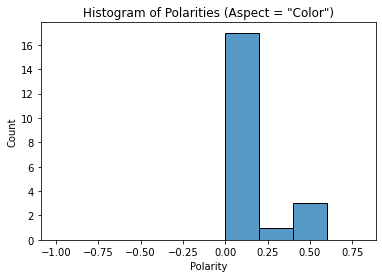

In [460]:
ax = sns.histplot(twitter_content2["Polarity"],
                  bins=np.arange(-1,1,0.2)
                  ).set_title('Histogram of Polarities (Aspect = "Color")')
plt.show()

In [461]:
# save the chart figure
fig = ax.get_figure()
fig.savefig('Polarity_Distribution.png', 
            dpi=75, 
            bbox_inches="tight")

# Descriptor Analysis (n-gramming)

In [462]:
positives = twitter_content2[twitter_content2["Polarity"] > 0] # polarity greater than 0
negatives = twitter_content2[twitter_content2["Polarity"] == 0] # polarity less than 0

In [463]:
from collections import Counter

In [464]:
def ngrams(text, n):
     return zip(*[text[i:] for i in range(n)])
     
def display_ngram_frequency(corpus, n, display):
    """
    Generate a DataFrame of n-grams and their frequencies.
    """
    ngram_counts = Counter(ngrams(corpus.split(), n))
    most_commmon = ngram_counts.most_common(display)

    ngram = []
    count = []
    for i in range(0,len(most_commmon)):
        ngram.append(" ".join(most_commmon[i][0]))
        count.append(most_commmon[i][1])

    if n > 3:
        col = f"{n}-gram"
    if n == 3:
        col = 'Tri-gram'
    if n == 2:
        col = 'Bi-gram'

    return pd.DataFrame(zip(ngram, count), columns=[col, "Count"])

In [465]:
# list all negative descriptors in a single string
descriptors_negative_opinions = negatives["Descriptors"].tolist()
descriptors_negative_opinions = " ".join(descriptors_negative_opinions)

# positives
descriptors_positive_opinions = positives["Descriptors"].tolist()
descriptors_positive_opinions = " ".join(descriptors_positive_opinions)

In [466]:
positives["Descriptors"]

4              slow
12                 
13    for available
14    for available
15    for available
Name: Descriptors, dtype: object

In [467]:
display_ngram_frequency(descriptors_positive_opinions, n=3
                        , display=4)

,Tri-gram,Count
0,for available for,2
1,available for available,2
2,slow for available,1


In [468]:
!pip install wordcloud

You should consider upgrading via the '/Users/ankushsingal/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [469]:
from wordcloud import WordCloud

def generate_wordcloud(text):
    """
    Generate word cloud images.
    """
    wordcloud = WordCloud(collocations=False, 
                          background_color="black",
                          max_words=50).generate(text)
    
    # set the figure size
    plt.figure(figsize=[8,10])

    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")

    # remove plot axes
    plt.axis("off")

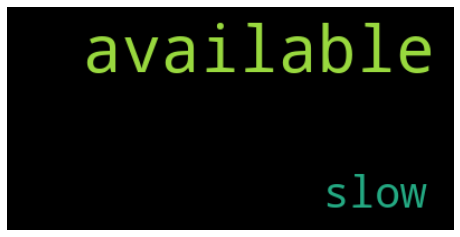

In [470]:
# WordCloud: descriptors extracted from negative opinions
generate_wordcloud(descriptors_positive_opinions)